In [1]:
# Import needed libaries
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# read in dataset and remove previouly set multiindex
df = pd.read_csv("process_data_df11.csv", header=[0,1], na_values=['nan'],
sep=',',low_memory=False)

# delet column without any information 
df.drop(['Unnamed: 0_level_0'],axis=1, inplace = True)
df = df.droplevel(level=0,axis=1)

# drop na and duplicates from qc_serien number since following assumption is made:
# every qc has one serial number, if it occurs twice the sample has been tested twice, since there are
# less than 1000 duplicates (less than 0.5 % of whole dataset) to keep them
df = df.dropna(subset = ['qc_serien_nummer']).drop_duplicates(subset = ['qc_serien_nummer'])#.set_index('qc_serien_nummer')


df = df[df['qc_salzrckhalt']!=0]
#df.to_pickle('test.pkl')

/home/alpha/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)



# Updating Reference and Richtwerte naming

    Renaming columns named richtwert into ref for easier filtering



In [2]:
# renaming columns named richtwert into ref for better filtering


df.rename(columns={'pa_cm-pda_gewichts-%_richtwert_ref_low':'pa_cm-pda_gewichts-%_ref_low'}, inplace=True)
df.rename(columns={'pa_cm-pda_gewichts-%_richtwert_ref_high':'pa_cm-pda_gewichts-%_ref_high'}, inplace=True)
df.rename(columns={'pa_chlorkonzentration_richtwert_low_ppm':'pa_chlorkonzentration_ref_low_ppm'}, inplace=True)
df.rename(columns={'pa_chlorkonzentration_richtwert_high_ppm':'pa_chlorkonzentration_ref_high_ppm'}, inplace=True)

In [3]:
df1 = df.copy()

In [4]:
result = pd.concat([df1.filter(regex = '_ref'),df1.filter(regex = '_richtwert_')], axis = 1, sort = False)
result1 = result.loc[:,~result.columns.duplicated()]
result2 = result1.join(df['p_product'])
result1.drop('pa_ref', axis=1, inplace = True)


In [5]:
Richtwerte = list(result1.columns)#.remove('p_product')

In [6]:
df1 = df1.drop(result1, axis = 1) #drop ref temporaly

In [7]:
df1['soll_salzr_rel']=(df1['qc_salzrckhalt']-df1['qc_minimalersalzrueckhalt'])/df1['qc_minimalersalzrueckhalt']*100
df1['soll_permeatd_rel']=(df1['qc_durchfluss']-df1['qc_minimalerdurchfluss'])/df1['qc_minimalerdurchfluss']*100

pauseee

filterdf = df1.filter(regex = 'pa_cm-pda')
filterdf

name = 'pa_cm-pda'+"_mean"

df1[name] = filterdf.iloc[:].mean(axis = 1)

df1

# Make mean columns


In [8]:
# Multiple Measurment columns
meanList = ['pa_cm-pda','pa_chlorkonzentration','pa_air-knife_vor_amin_bad','airknife_vor_amin_trockner',
            'pa_amin-trockner_feuchtigkeit_danfugt_bs',
            'pa_amin-trockner_feuchtigkeit_danfugt_as',
            'pa_amin-trockner_feuchtigkeit_cofely',
            'ps_dicke','ps_bad_temperatur',
            'ps_auftragswerk_feuchtigkeit',
            'sc_d_links_werte',
            'sc_d_rechts_werte']

# Funktion to drop multiple measurment values
def MeanColumnCreate(meanList, df):
  for i in meanList:
      filterdf = df.filter(regex = i)
      name = i+"_mean"
      df[name] = filterdf.iloc[:].mean(axis = 1)
      df.drop(filterdf, axis = 1, inplace = True)
    
MeanColumnCreate(meanList, df1)

# Rename air-knife vor amin bad mean to airknife ....
df1.rename(columns={'pa_air-knife_vor_amin_bad_mean':'pa_airknife_vor_amin_bad_mean'}, inplace=True)

In [9]:
df2 = df1.copy()

In [10]:
# rejoin refvalues back to dataframe
df2 = df2.join(result1)

In [11]:
#pauseeee

# Lists for name pattern search

    List has been created manually



In [12]:
# List of features that have low and high reference values
RefDouble =  ['pa_cm-pda','pa_chlorkonzentration',
            'airknife_vor_amin_trockner',
            'pa_amin-trockner_feuchtigkeit_danfugt_bs',
            'pa_amin-trockner_feuchtigkeit_danfugt_as',
            'pa_amin-trockner_feuchtigkeit_cofely',
            'pa_vertikale_feuchte_oben',
            'pa_temperatur_n-decan-lsg', 
            'pa_temperatur_alkali-lsg']

# List of features that have only one reference value
RefSingle = ['pa_bahngeschwindigkeit', 'ct1',
                 'pa_staubsauger',
                 'pa_airknife_vor_amin_bad',
                 'pa_amin-trockner_temperatur_danfugt',
                 'pa_decan-trockner_geblase']

In [13]:
df3 = df2.copy()

# Function for calculating with low and high ref value


In [14]:
def doubleRef(df, RefListDouble):
    for i in RefListDouble:
        mask = df.filter(regex = i)
        mean = list(mask.filter(regex = i).columns)[0]  # because mean is vor ref values
        low = list(mask.filter(regex = 'ref').columns)[0] #columname of corresponding low ref column
        high = list(mask.filter(regex = 'ref').columns)[1] #columname of corresponding high ref column
        
        # Creating temporaly columns via boolean indexing
        # Only one per row of the temporaly made columns is filled with values (Boolean Array like)
        
        df[i+"_diff_low"] = np.where((df[mean] < df[low]),(df[mean]-df[low]), 0)
        #df[i+"_diff_low"] = np.where((df[mean] < df[low]),(df[low] -df[mean]), 0) 
        df[i+"_diff_high"] = np.where((df[mean] > df[high]),(df[high] -df3[mean]), 0)
        df[i+"diff_none"] = np.where((df[mean] <df[high]) & (df[mean]>df[low]),(df[mean]-df[mean]), 0)
        
        # Create difference column and drop all temporaliy made columns
        
        df[i+"_diff"] = df[i+"_diff_low"]+df[i+"_diff_high"]+df[i+"diff_none"]  
        df.drop([i+"_diff_low" ,i+"_diff_high",i+"diff_none"], axis = 1, inplace = True)


In [15]:
doubleRef(df3,RefDouble)

# Calulate for ct1_values the diff between ref and high


In [16]:
ct1FeatureList = list(df3.filter(regex = 'ct1_').columns)[:-2]
ct1RefList = list(df3.filter(regex = 'ct1_').columns)[8:]

ct1FeatureList

['ct1_anfang_0m_%',
 'ct1_anfang_flux_m3/m2/d',
 'ct1_mitte_1_1400m_rej_%',
 'ct1_mitte_1_1400m_flux',
 'ct1_mitte_2_2900m_rej_%',
 'ct1_mitte_2_2900m_flux',
 'ct1_ende_4300m_rej_%',
 'ct1_ende_flux_m3/m2/d']

In [17]:
ct1RefList



['ct1_test_ref_low', 'ct1_test_ref_high']

In [18]:
df3.filter(regex = 'ct1')

,ct1_anfang_0m_%,ct1_anfang_flux_m3/m2/d,ct1_mitte_1_1400m_rej_%,ct1_mitte_1_1400m_flux,ct1_mitte_2_2900m_rej_%,ct1_mitte_2_2900m_flux,ct1_ende_4300m_rej_%,ct1_ende_flux_m3/m2/d,ct1_test_ref_low,ct1_test_ref_high
0,99.63,1.49,99.54,1.65,99.58,1.52,99.72,1.49,1.12,99.1
1,99.63,1.49,99.54,1.65,99.58,1.52,99.72,1.49,1.12,99.1
2,99.63,1.49,99.54,1.65,99.58,1.52,99.72,1.49,1.12,99.1
3,99.63,1.49,99.54,1.65,99.58,1.52,99.72,1.49,1.12,99.1
4,99.63,1.49,99.54,1.65,99.58,1.52,99.72,1.49,1.12,99.1
...,...,...,...,...,...,...,...,...,...,...
118665,99.51,1.37,99.49,1.43,0.00,0.00,0.00,0.00,1.12,99.1
118666,99.51,1.37,99.49,1.43,0.00,0.00,0.00,0.00,1.12,99.1
118667,99.51,1.37,99.49,1.43,0.00,0.00,0.00,0.00,1.12,99.1
118668,99.51,1.37,99.49,1.43,0.00,0.00,0.00,0.00,1.12,99.1


In [19]:
for i in ct1FeatureList:
    
        low = ct1RefList[0] #columname of corresponding low ref column
        high = ct1RefList[1] #columname of corresponding high ref column
        
        # Creating temporaly columns via boolean indexing
        # Only one per row of the temporaly made columns is filled with values (Boolean Array like)
        
        df3[i+"_diff_low"] = np.where((df3[i] < df3[low]),(df3[i]-df3[low]), 0) 
        df3[i+"_diff_high"] = np.where((df3[i] > df3[high]),(df3[i] - df3[high]), 0)
        df3[i+"diff_none"] = np.where((df3[i] <df3[high]) & (df3[i]>df3[low]),(df3[i]-df3[i]), 0)
        
        # Create difference column and drop all temporaliy made columns
        
        df3[i+"_diff"] = df3[i+"_diff_low"]+df3[i+"_diff_high"]+df3[i+"diff_none"]  
        #df3.drop([i+"_diff_low" ,i+"_diff_high",i+"diff_none"], axis = 1, inplace = True)

In [20]:
df4 = df3.copy()

In [21]:
dada = []
for i in RefSingle:
    mask = df.filter(regex = i)
    names = mask.columns
    dada.append(names)

    
flat_list = []
for sublist in dada:
    for item in sublist:
        flat_list.append(item)
print(flat_list)

['ct1_anfang_0m_%', 'ct1_anfang_flux_m3/m2/d', 'ct1_mitte_1_1400m_rej_%', 'ct1_mitte_1_1400m_flux', 'ct1_mitte_2_2900m_rej_%', 'ct1_mitte_2_2900m_flux', 'ct1_ende_4300m_rej_%', 'ct1_ende_flux_m3/m2/d', 'ct1_test_ref_low', 'ct1_test_ref_high', 'pa_airknife_vor_amin_bad_ref_%', 'pa_amin-trockner_temperatur_danfugt_c', 'pa_amin-trockner_temperatur_danfugt_ref_c', 'pa_decan-trockner_geblase_start_%', 'pa_decan-trockner_geblase_ende_%', 'pa_decan-trockner_geblase_ref_%']


# Function to calculate for single Reference value¶


In [22]:
restSingleVar =['pa_airknife_vor_amin_bad_mean',
                'pa_amin-trockner_temperatur_danfugt_c',  
                'pa_decan-trockner_geblase_start_%', 
                'pa_decan-trockner_geblase_ende_%', 
                ]

restSingleRef = ['pa_airknife_vor_amin_bad_ref_%',
                'pa_amin-trockner_temperatur_danfugt_ref_c',
                'pa_decan-trockner_geblase_ref_%',
                'pa_decan-trockner_geblase_ref_%']


In [23]:
c=(zip(restSingleVar,restSingleRef))
for i,j in zip(restSingleVar,restSingleRef):
    print("{},{}".format(i,j))

pa_airknife_vor_amin_bad_mean,pa_airknife_vor_amin_bad_ref_%
pa_amin-trockner_temperatur_danfugt_c,pa_amin-trockner_temperatur_danfugt_ref_c
pa_decan-trockner_geblase_start_%,pa_decan-trockner_geblase_ref_%
pa_decan-trockner_geblase_ende_%,pa_decan-trockner_geblase_ref_%


In [24]:
for a,b in zip(restSingleVar,restSingleRef):
     
    df4[a+"_diff"] = np.where((df4[a] > df4[b]) | (df4[a]<df4[b]),(df4[a]-df4[b]), 0)

In [25]:
df5=df4.select_dtypes(include=['float64','int']) 

# Turn all _diff named columns into abs() values


diff = list(df5.filter(regex = 'diff').columns)
for i in diff:
    df5[i] = df5[i].abs()

In [26]:
#df4.columns

In [27]:
df6=df4.filter(regex=r'(mean|soll_salzr_rel|soll_permeatd_rel)')
df7=df5.filter(regex=r'(_diff|soll_salzr_rel|soll_permeatd_rel)')

In [28]:
df6

,soll_salzr_rel,soll_permeatd_rel,pa_cm-pda_mean,pa_chlorkonzentration_mean,pa_airknife_vor_amin_bad_mean,airknife_vor_amin_trockner_mean,pa_amin-trockner_feuchtigkeit_danfugt_bs_mean,pa_amin-trockner_feuchtigkeit_danfugt_as_mean,pa_amin-trockner_feuchtigkeit_cofely_mean,ps_dicke_mean,ps_bad_temperatur_mean,ps_auftragswerk_feuchtigkeit_mean,sc_d_links_werte_mean,sc_d_rechts_werte_mean,pa_airknife_vor_amin_bad_mean_diff
0,0.257196,27.397956,2.332222,1558.000000,80.0,40.00,57.0,56.0,79.8500,134.785714,21.688889,75.625,0.0,0.0,0.0
1,0.333070,27.290961,2.332222,1558.000000,80.0,40.00,57.0,56.0,79.8500,134.785714,21.688889,75.625,0.0,0.0,0.0
2,0.325927,25.601603,2.332222,1558.000000,80.0,40.00,57.0,56.0,79.8500,134.785714,21.688889,75.625,0.0,0.0,0.0
3,0.370513,24.726399,2.332222,1558.000000,80.0,40.00,57.0,56.0,79.8500,134.785714,21.688889,75.625,0.0,0.0,0.0
4,0.380436,25.644707,2.332222,1558.000000,80.0,40.00,57.0,56.0,79.8500,134.785714,21.688889,75.625,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118665,0.206536,14.314983,1.402222,913.555556,40.0,18.75,35.8,34.4,39.7875,133.571429,12.300000,27.625,0.0,0.0,-40.0
118666,0.255234,12.723639,1.402222,913.555556,40.0,18.75,35.8,34.4,39.7875,133.571429,12.300000,27.625,0.0,0.0,-40.0
118667,0.209330,10.327625,1.402222,913.555556,40.0,18.75,35.8,34.4,39.7875,133.571429,12.300000,27.625,0.0,0.0,-40.0
118668,0.287117,19.288324,1.402222,913.555556,40.0,18.75,35.8,34.4,39.7875,133.571429,12.300000,27.625,0.0,0.0,-40.0


In [29]:
df7

,soll_salzr_rel,soll_permeatd_rel,pa_cm-pda_diff,pa_chlorkonzentration_diff,airknife_vor_amin_trockner_diff,pa_amin-trockner_feuchtigkeit_danfugt_bs_diff,pa_amin-trockner_feuchtigkeit_danfugt_as_diff,pa_amin-trockner_feuchtigkeit_cofely_diff,pa_vertikale_feuchte_oben_diff,pa_temperatur_n-decan-lsg_diff,...,ct1_ende_4300m_rej_%_diff_low,ct1_ende_4300m_rej_%_diff_high,ct1_ende_4300m_rej_%_diff,ct1_ende_flux_m3/m2/d_diff_low,ct1_ende_flux_m3/m2/d_diff_high,ct1_ende_flux_m3/m2/d_diff,pa_airknife_vor_amin_bad_mean_diff,pa_amin-trockner_temperatur_danfugt_c_diff,pa_decan-trockner_geblase_start_%_diff,pa_decan-trockner_geblase_ende_%_diff
0,0.257196,27.397956,0.000000,-2.000000,0.0,0.0,-1.0,0.0000,-6.0,-1.75,...,0.00,0.62,0.62,0.00,0.0,0.00,0.0,0.0,0.0,-80.0
1,0.333070,27.290961,0.000000,-2.000000,0.0,0.0,-1.0,0.0000,-6.0,-1.75,...,0.00,0.62,0.62,0.00,0.0,0.00,0.0,0.0,0.0,-80.0
2,0.325927,25.601603,0.000000,-2.000000,0.0,0.0,-1.0,0.0000,-6.0,-1.75,...,0.00,0.62,0.62,0.00,0.0,0.00,0.0,0.0,0.0,-80.0
3,0.370513,24.726399,0.000000,-2.000000,0.0,0.0,-1.0,0.0000,-6.0,-1.75,...,0.00,0.62,0.62,0.00,0.0,0.00,0.0,0.0,0.0,-80.0
4,0.380436,25.644707,0.000000,-2.000000,0.0,0.0,-1.0,0.0000,-6.0,-1.75,...,0.00,0.62,0.62,0.00,0.0,0.00,0.0,0.0,0.0,-80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118665,0.206536,14.314983,-0.897778,-646.444444,0.0,-21.2,-22.6,-39.2125,-3.0,0.00,...,-1.12,0.00,-1.12,-1.12,0.0,-1.12,-40.0,0.0,0.0,-80.0
118666,0.255234,12.723639,-0.897778,-646.444444,0.0,-21.2,-22.6,-39.2125,-3.0,0.00,...,-1.12,0.00,-1.12,-1.12,0.0,-1.12,-40.0,0.0,0.0,-80.0
118667,0.209330,10.327625,-0.897778,-646.444444,0.0,-21.2,-22.6,-39.2125,-3.0,0.00,...,-1.12,0.00,-1.12,-1.12,0.0,-1.12,-40.0,0.0,0.0,-80.0
118668,0.287117,19.288324,-0.897778,-646.444444,0.0,-21.2,-22.6,-39.2125,-3.0,0.00,...,-1.12,0.00,-1.12,-1.12,0.0,-1.12,-40.0,0.0,0.0,-80.0


In [30]:
df8=df7.loc[:,(df7!=0).any(axis=0)]
df8

,soll_salzr_rel,soll_permeatd_rel,pa_cm-pda_diff,pa_chlorkonzentration_diff,airknife_vor_amin_trockner_diff,pa_amin-trockner_feuchtigkeit_danfugt_bs_diff,pa_amin-trockner_feuchtigkeit_danfugt_as_diff,pa_amin-trockner_feuchtigkeit_cofely_diff,pa_vertikale_feuchte_oben_diff,pa_temperatur_n-decan-lsg_diff,...,ct1_ende_4300m_rej_%_diff_low,ct1_ende_4300m_rej_%_diff_high,ct1_ende_4300m_rej_%_diff,ct1_ende_flux_m3/m2/d_diff_low,ct1_ende_flux_m3/m2/d_diff_high,ct1_ende_flux_m3/m2/d_diff,pa_airknife_vor_amin_bad_mean_diff,pa_amin-trockner_temperatur_danfugt_c_diff,pa_decan-trockner_geblase_start_%_diff,pa_decan-trockner_geblase_ende_%_diff
0,0.257196,27.397956,0.000000,-2.000000,0.0,0.0,-1.0,0.0000,-6.0,-1.75,...,0.00,0.62,0.62,0.00,0.0,0.00,0.0,0.0,0.0,-80.0
1,0.333070,27.290961,0.000000,-2.000000,0.0,0.0,-1.0,0.0000,-6.0,-1.75,...,0.00,0.62,0.62,0.00,0.0,0.00,0.0,0.0,0.0,-80.0
2,0.325927,25.601603,0.000000,-2.000000,0.0,0.0,-1.0,0.0000,-6.0,-1.75,...,0.00,0.62,0.62,0.00,0.0,0.00,0.0,0.0,0.0,-80.0
3,0.370513,24.726399,0.000000,-2.000000,0.0,0.0,-1.0,0.0000,-6.0,-1.75,...,0.00,0.62,0.62,0.00,0.0,0.00,0.0,0.0,0.0,-80.0
4,0.380436,25.644707,0.000000,-2.000000,0.0,0.0,-1.0,0.0000,-6.0,-1.75,...,0.00,0.62,0.62,0.00,0.0,0.00,0.0,0.0,0.0,-80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118665,0.206536,14.314983,-0.897778,-646.444444,0.0,-21.2,-22.6,-39.2125,-3.0,0.00,...,-1.12,0.00,-1.12,-1.12,0.0,-1.12,-40.0,0.0,0.0,-80.0
118666,0.255234,12.723639,-0.897778,-646.444444,0.0,-21.2,-22.6,-39.2125,-3.0,0.00,...,-1.12,0.00,-1.12,-1.12,0.0,-1.12,-40.0,0.0,0.0,-80.0
118667,0.209330,10.327625,-0.897778,-646.444444,0.0,-21.2,-22.6,-39.2125,-3.0,0.00,...,-1.12,0.00,-1.12,-1.12,0.0,-1.12,-40.0,0.0,0.0,-80.0
118668,0.287117,19.288324,-0.897778,-646.444444,0.0,-21.2,-22.6,-39.2125,-3.0,0.00,...,-1.12,0.00,-1.12,-1.12,0.0,-1.12,-40.0,0.0,0.0,-80.0


In [31]:
df9=df8[~(df8 ==0).all(axis=1)]
df9

,soll_salzr_rel,soll_permeatd_rel,pa_cm-pda_diff,pa_chlorkonzentration_diff,airknife_vor_amin_trockner_diff,pa_amin-trockner_feuchtigkeit_danfugt_bs_diff,pa_amin-trockner_feuchtigkeit_danfugt_as_diff,pa_amin-trockner_feuchtigkeit_cofely_diff,pa_vertikale_feuchte_oben_diff,pa_temperatur_n-decan-lsg_diff,...,ct1_ende_4300m_rej_%_diff_low,ct1_ende_4300m_rej_%_diff_high,ct1_ende_4300m_rej_%_diff,ct1_ende_flux_m3/m2/d_diff_low,ct1_ende_flux_m3/m2/d_diff_high,ct1_ende_flux_m3/m2/d_diff,pa_airknife_vor_amin_bad_mean_diff,pa_amin-trockner_temperatur_danfugt_c_diff,pa_decan-trockner_geblase_start_%_diff,pa_decan-trockner_geblase_ende_%_diff
0,0.257196,27.397956,0.000000,-2.000000,0.0,0.0,-1.0,0.0000,-6.0,-1.75,...,0.00,0.62,0.62,0.00,0.0,0.00,0.0,0.0,0.0,-80.0
1,0.333070,27.290961,0.000000,-2.000000,0.0,0.0,-1.0,0.0000,-6.0,-1.75,...,0.00,0.62,0.62,0.00,0.0,0.00,0.0,0.0,0.0,-80.0
2,0.325927,25.601603,0.000000,-2.000000,0.0,0.0,-1.0,0.0000,-6.0,-1.75,...,0.00,0.62,0.62,0.00,0.0,0.00,0.0,0.0,0.0,-80.0
3,0.370513,24.726399,0.000000,-2.000000,0.0,0.0,-1.0,0.0000,-6.0,-1.75,...,0.00,0.62,0.62,0.00,0.0,0.00,0.0,0.0,0.0,-80.0
4,0.380436,25.644707,0.000000,-2.000000,0.0,0.0,-1.0,0.0000,-6.0,-1.75,...,0.00,0.62,0.62,0.00,0.0,0.00,0.0,0.0,0.0,-80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118665,0.206536,14.314983,-0.897778,-646.444444,0.0,-21.2,-22.6,-39.2125,-3.0,0.00,...,-1.12,0.00,-1.12,-1.12,0.0,-1.12,-40.0,0.0,0.0,-80.0
118666,0.255234,12.723639,-0.897778,-646.444444,0.0,-21.2,-22.6,-39.2125,-3.0,0.00,...,-1.12,0.00,-1.12,-1.12,0.0,-1.12,-40.0,0.0,0.0,-80.0
118667,0.209330,10.327625,-0.897778,-646.444444,0.0,-21.2,-22.6,-39.2125,-3.0,0.00,...,-1.12,0.00,-1.12,-1.12,0.0,-1.12,-40.0,0.0,0.0,-80.0
118668,0.287117,19.288324,-0.897778,-646.444444,0.0,-21.2,-22.6,-39.2125,-3.0,0.00,...,-1.12,0.00,-1.12,-1.12,0.0,-1.12,-40.0,0.0,0.0,-80.0


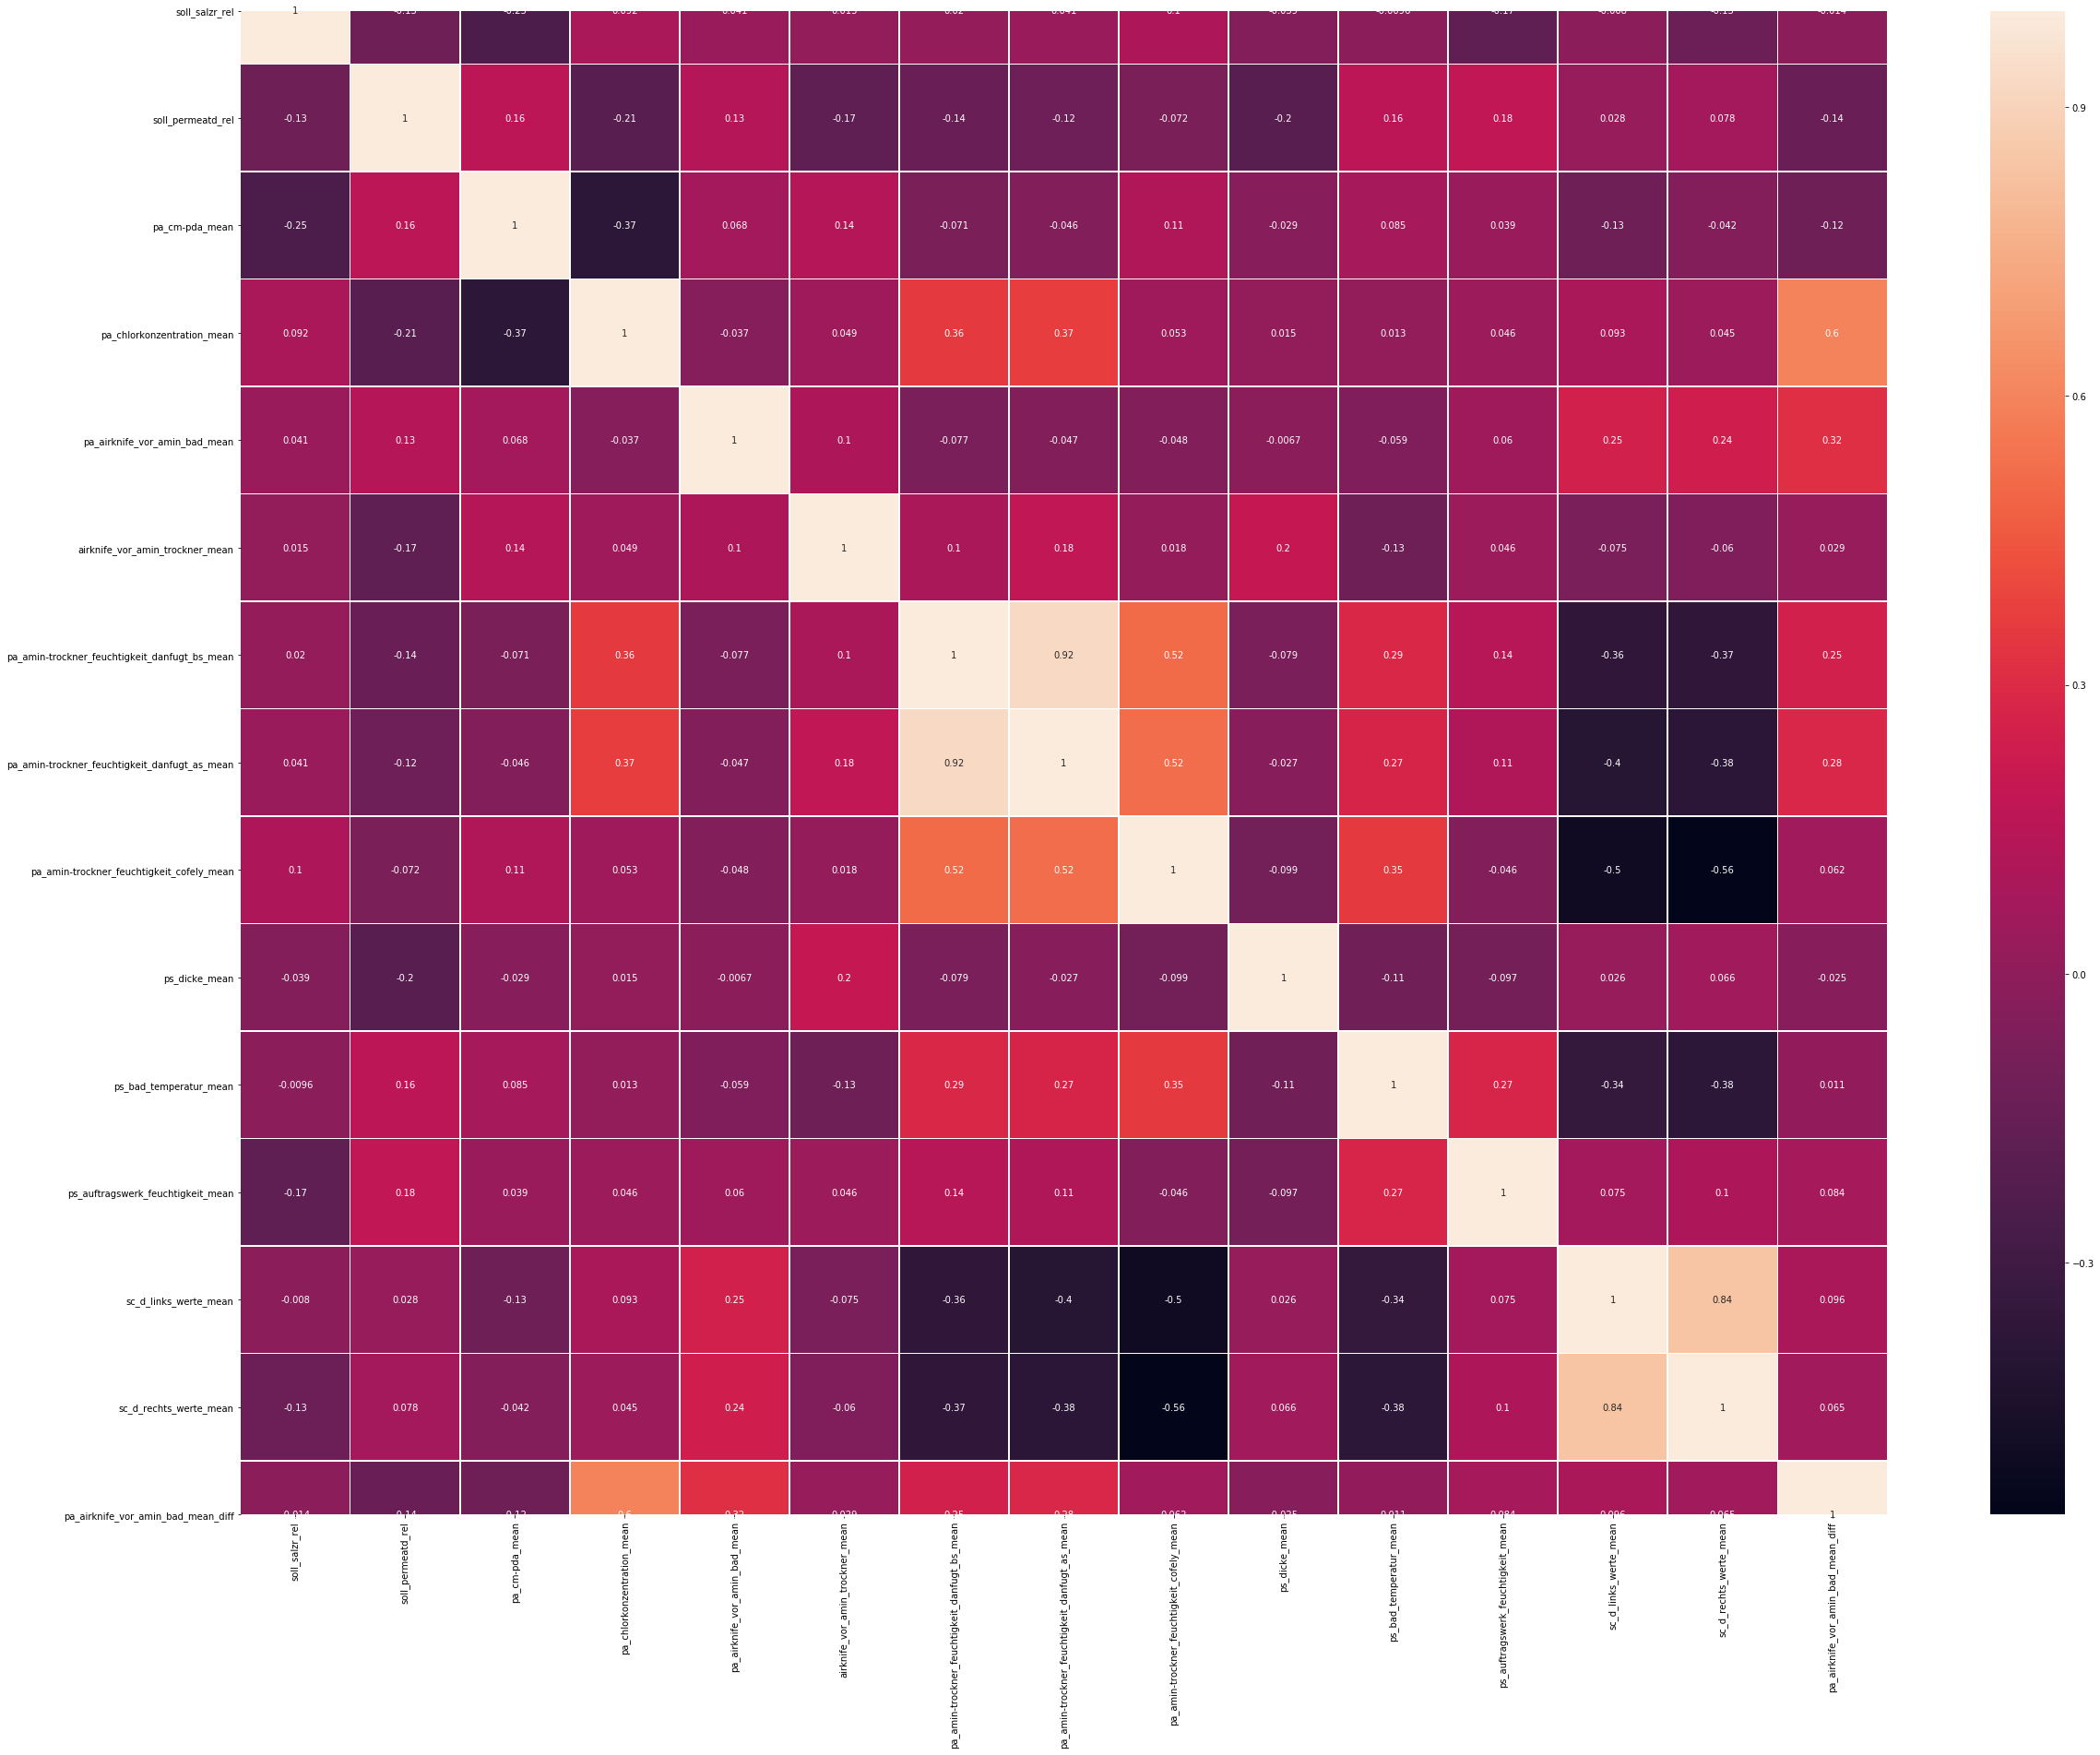

In [32]:
plt.figure(figsize=(40, 30))
p = sns.heatmap(df6.corr(method='spearman'), annot=True, linewidths=.5)
plt.savefig('mean_sp_all.pdf')

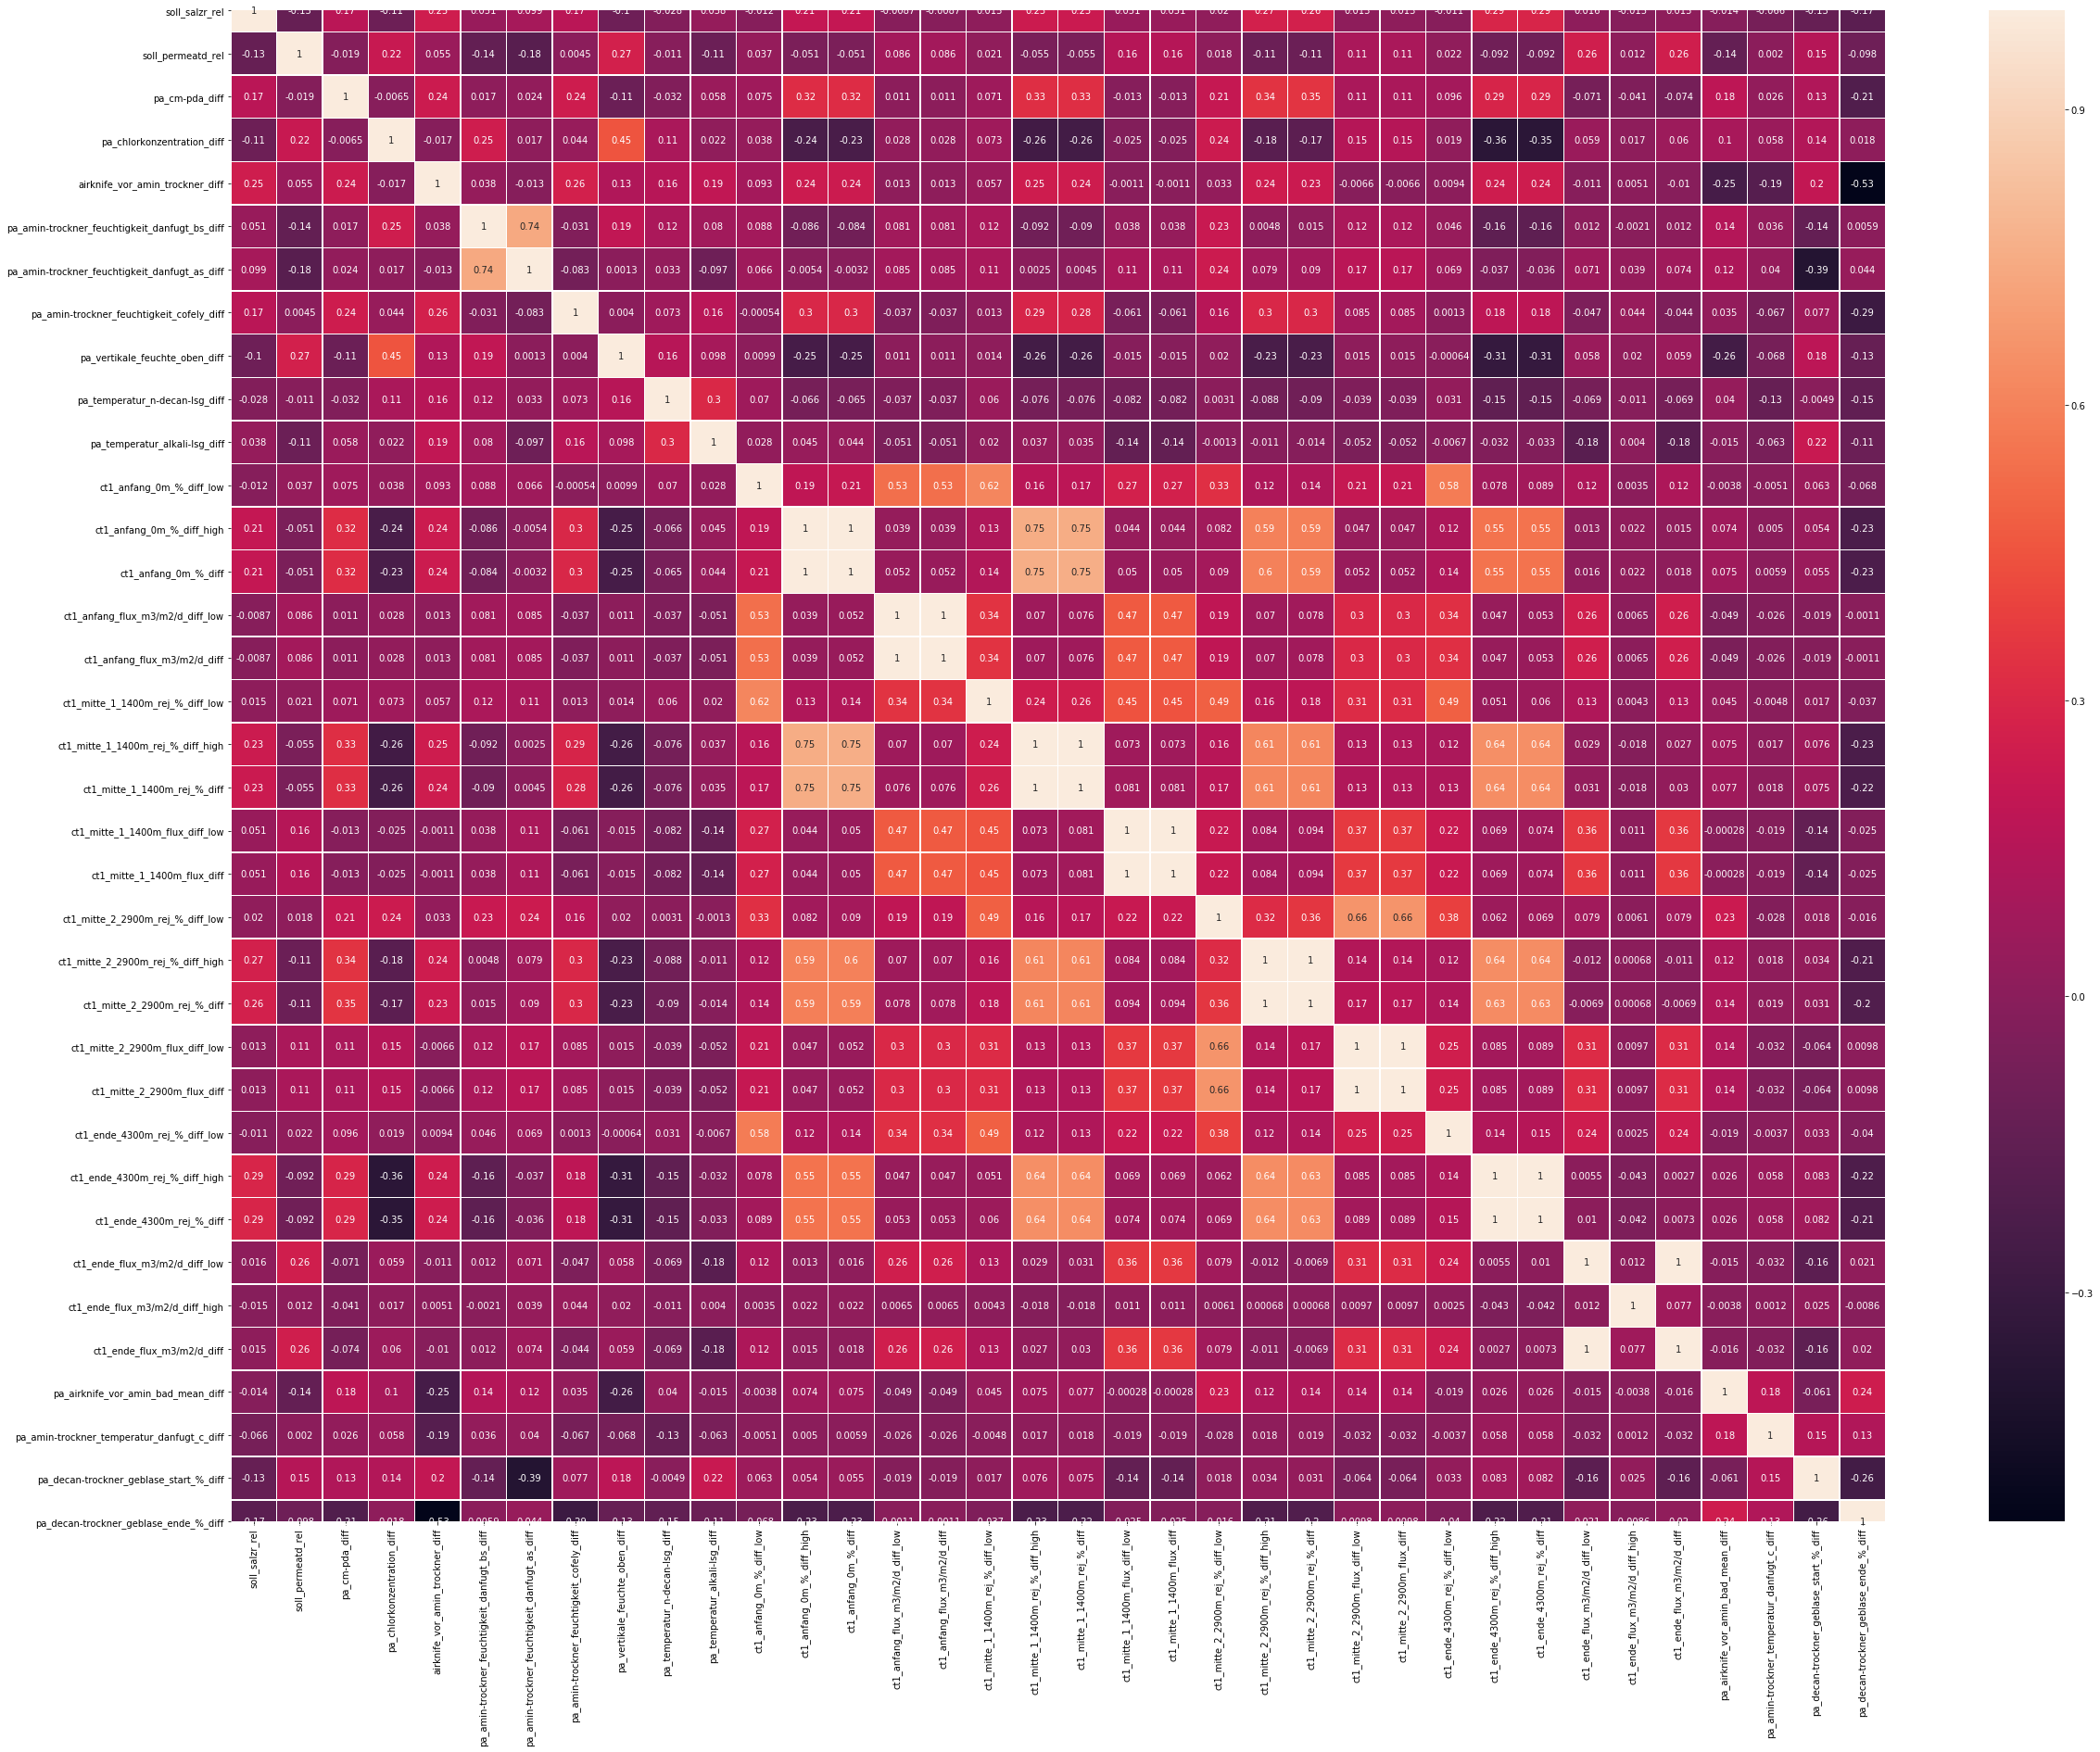

In [33]:
plt.figure(figsize=(40, 30))
p = sns.heatmap(df9.corr(method='spearman'), annot=True, linewidths=.5)
plt.savefig('diff_sp_all.pdf')

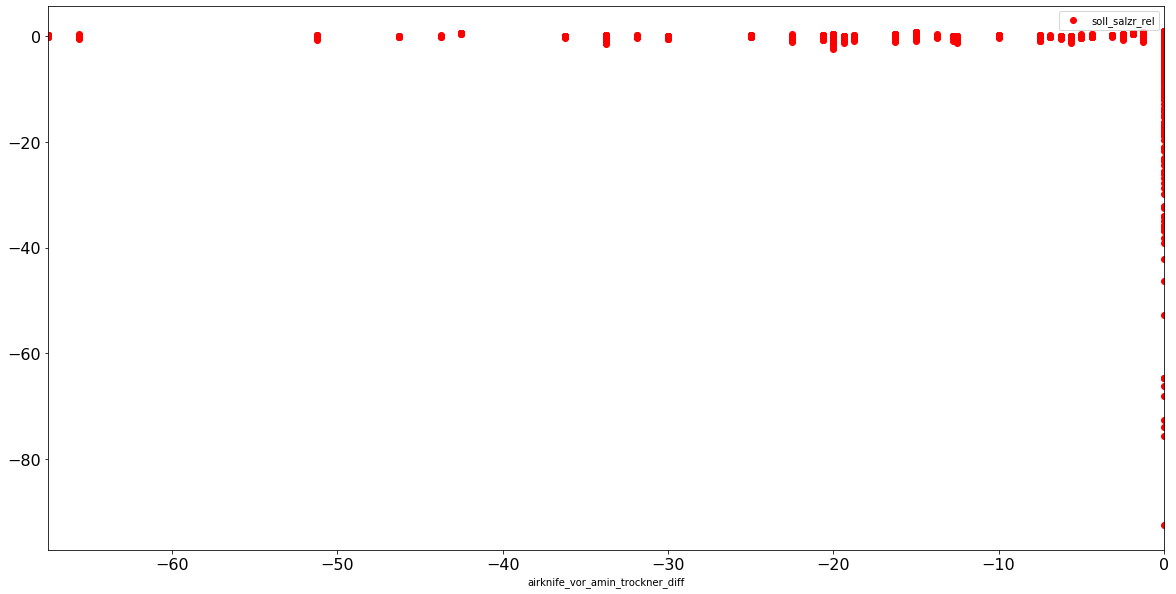

In [34]:
df9.plot(fontsize=16,
         x='airknife_vor_amin_trockner_diff',
         #xlim=(-300,0),
         y='soll_salzr_rel',
         #ylim=(-80,-1),
         style='ro',
         figsize=(20,10))

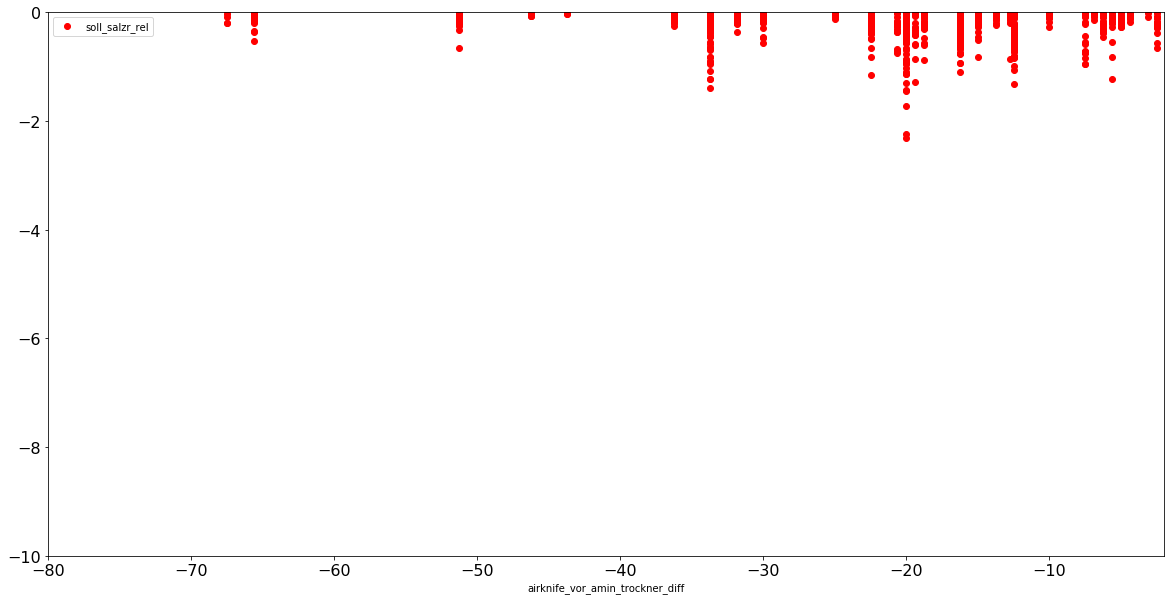

In [41]:
df9.plot(fontsize=16,
         x='airknife_vor_amin_trockner_diff',
         xlim=(-80,-2),
         y='soll_salzr_rel',
         ylim=(-10,0),
         style='ro',
         figsize=(20,10))

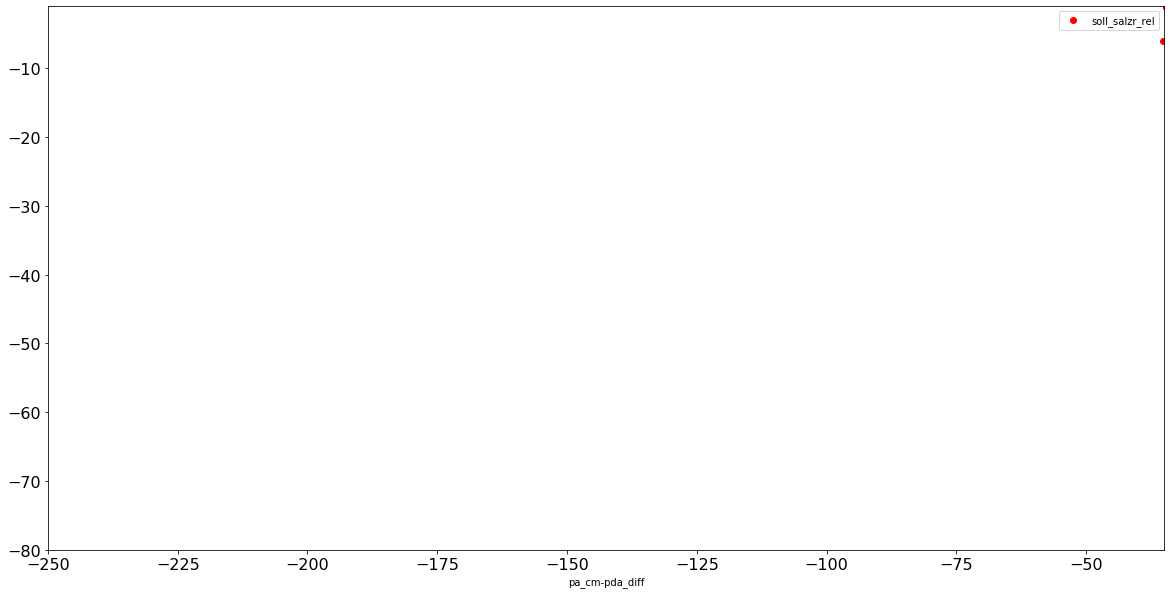

In [36]:
df9.plot(fontsize=16,
         x='pa_cm-pda_diff',
         xlim=(-250,-35),
         y='soll_salzr_rel',
         ylim=(-80,-1),
         style='ro',
         figsize=(20,10))

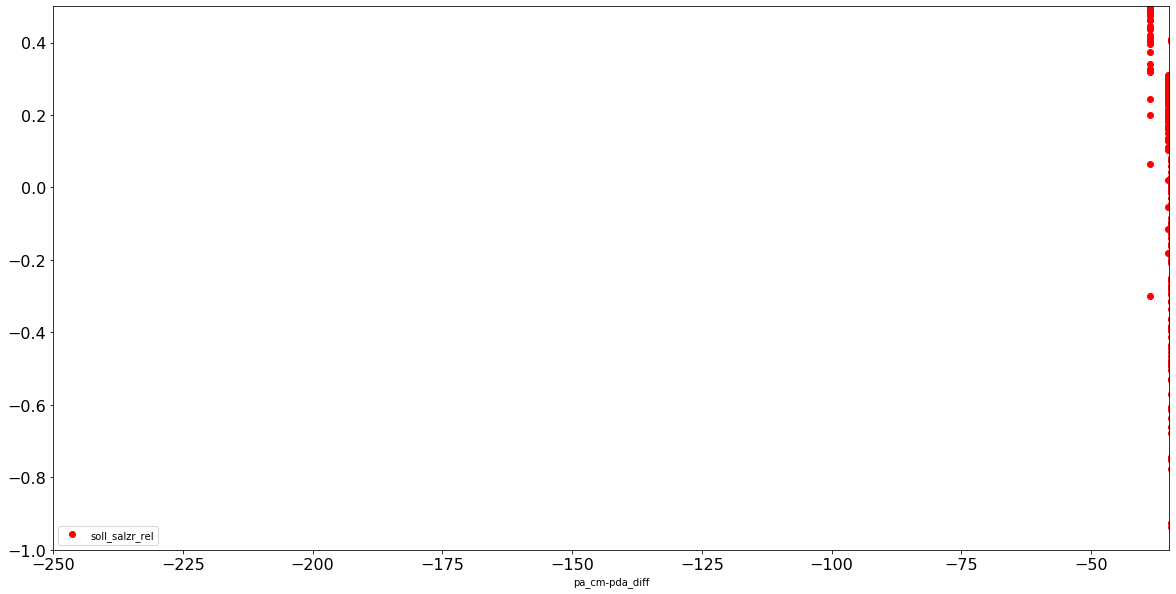

In [37]:
df9.plot(fontsize=16,
         x='pa_cm-pda_diff',
         xlim=(-250,-35),
         y='soll_salzr_rel',
         ylim=(-1,0.5),
         style='ro',
         figsize=(20,10))

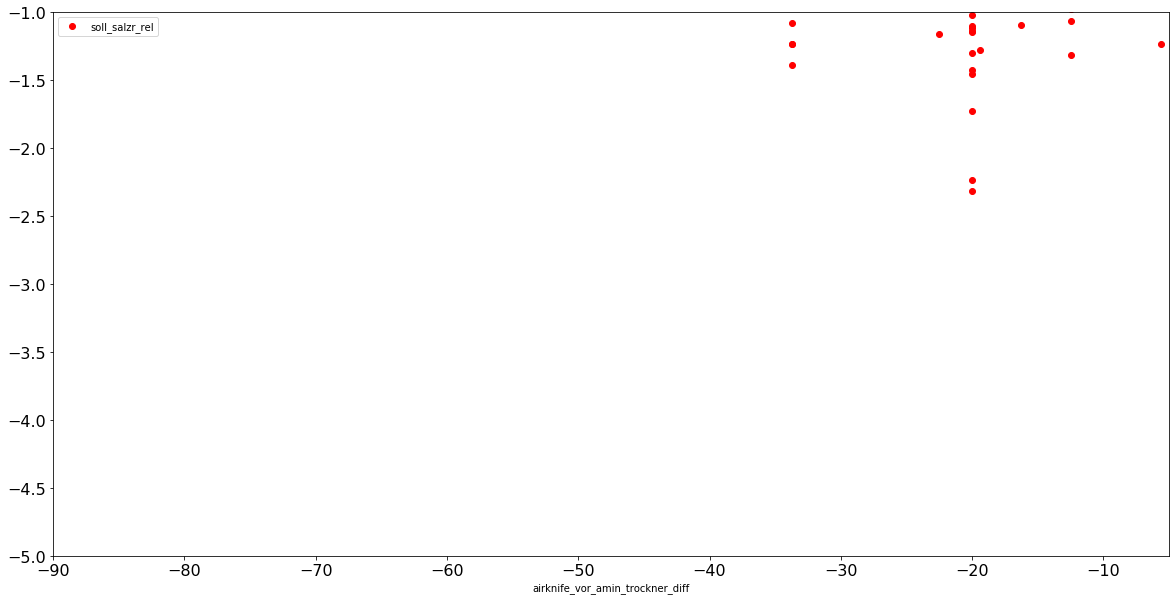

In [42]:
df9.plot(fontsize=16,
         x='airknife_vor_amin_trockner_diff',
         xlim=(-90,-5),
         y='soll_salzr_rel',
         ylim=(-5,-1),
         style='ro',
         figsize=(20,10))

df6.plot(fontsize=16,
         x='pa_amin-trockner_feuchtigkeit_cofely_mean',
         xlim=(0,150),
         y='soll_salzr_rel',
         #ylim=(-100,-1),
         style='ro',
         figsize=(20,10))

In [40]:
dfbla=df1.filter(regex = 'mean')